## Code 생성

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

## 송신단에서의 신호 생성 + Doppler_frequency 적용

In [77]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*4, signal_length=1023*4):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(4)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
    # t = np.repeat(t, 4)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## 수신단에서의 Replica 신호 생성(For Acquisition)

In [78]:
def generate_replica_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*4, signal_length=1023*4):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(4)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
    # t = np.repeat(t, 4)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## Acquisition

In [79]:

"""
def acquisition(signal, code_delay_range, doppler_freq_range, svNumber, doppler_freq_step=500, oversampling_factor=(1.023e6)*4, signal_length=1023*4):
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
 
    for i, doppler_freq in enumerate(doppler_freq_range):
        reference_signal = generate_replica_signal(code_delay_range[0], doppler_freq,svNumber, oversampling_factor=oversampling_factor, signal_length=signal_length)
        
        for j in range(len(code_delay_range)//2): ## 원래 len(code_delay_range) //2
            correlation = np.abs(correlate(signal, reference_signal, mode='valid'))
            
            # Find maximum correlation
            peak_corr = np.max(correlation)
            corr_matrix[j, i] = peak_corr
            
            if peak_corr > max_corr:
                max_corr = peak_corr
                max_code_delay = code_delay_range[j*2]//4
                max_doppler_freq = doppler_freq
            reference_signal = np.roll(reference_signal,2) # shift for 0.5 chip
            
            
    return max_corr, max_code_delay, max_doppler_freq, corr_matrix
 """   

"\ndef acquisition(signal, code_delay_range, doppler_freq_range, svNumber, doppler_freq_step=500, oversampling_factor=(1.023e6)*4, signal_length=1023*4):\n    max_corr = 0\n    max_code_delay = 0\n    max_doppler_freq = 0\n    \n    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))\n \n    for i, doppler_freq in enumerate(doppler_freq_range):\n        reference_signal = generate_replica_signal(code_delay_range[0], doppler_freq,svNumber, oversampling_factor=oversampling_factor, signal_length=signal_length)\n        \n        for j in range(len(code_delay_range)//2): ## 원래 len(code_delay_range) //2\n            correlation = np.abs(correlate(signal, reference_signal, mode='valid'))\n            \n            # Find maximum correlation\n            peak_corr = np.max(correlation)\n            corr_matrix[j, i] = peak_corr\n            \n            if peak_corr > max_corr:\n                max_corr = peak_corr\n                max_code_delay = code_delay_range[j*2]/

 *수정된 Acquisition - plot위한*

In [80]:
import numpy as np
from scipy.signal import correlate

def acquisition(signal, code_delay_range, doppler_freq_range, svNumber, doppler_freq_step=500, oversampling_factor=(1.023e6)*4, signal_length=1023*4):
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
 
    for i, doppler_freq in enumerate(doppler_freq_range):
        for j, code_delay in enumerate(code_delay_range):
            # Generate replica signal with the current code delay and Doppler frequency
            reference_signal = generate_replica_signal(code_delay, doppler_freq, svNumber, oversampling_factor=oversampling_factor, signal_length=signal_length)

            # Calculate correlation between the received signal and the replica signal
            correlation = np.abs(correlate(signal, reference_signal, mode='valid'))
            
            # Find maximum correlation
            peak_corr = np.max(correlation)
            corr_matrix[j, i] = peak_corr
            
            # Update maximum correlation and corresponding code delay and Doppler frequency
            if peak_corr > max_corr:
                max_corr = peak_corr
                max_code_delay = code_delay // 4
                max_doppler_freq = doppler_freq
    
            # Shift the reference signal by 0.5 chips (2 samples) for the next iteration
            reference_signal = np.roll(reference_signal, 2)
    
    return max_corr, max_code_delay, max_doppler_freq, corr_matrix
    


## 실행

In [81]:
# Parameters
code_delay_range = list(range(-800, 800))  # Range of code delay in chips
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = rand.randint(0,36)
# Generate received signal
true_code_delay = rand.randint(-800,800)
true_doppler_freq = rand.randint(-5000,5000)
received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq=code_freq)

# Perform acquisition
max_corr, estimated_code_delay, estimated_doppler_freq, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, svNumber)

print("-"*40)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay / 4)
print("True doppler frequency:", true_doppler_freq)
print("Maximum correlation:", max_corr)
print("Estimated code delay:", estimated_code_delay)
print("Estimated Doppler frequency:", estimated_doppler_freq)

----------------------------------------
Target SV Number: 6
True Code Delay: 41.0
True doppler frequency: 2143
Maximum correlation: 1977.869353932867
Estimated code delay: 40
Estimated Doppler frequency: 2000.0


## Plot

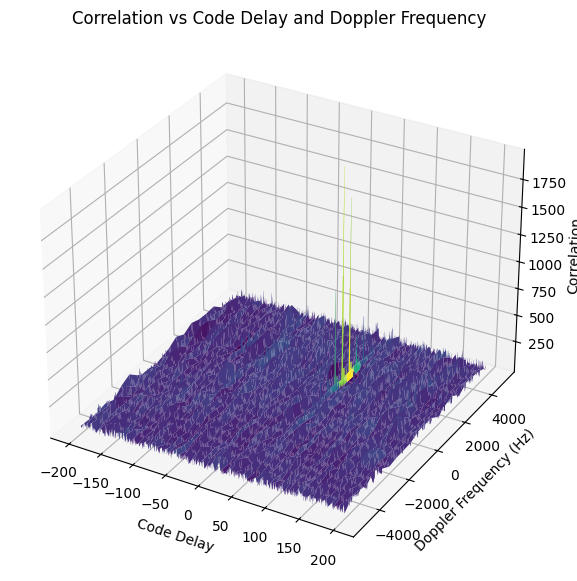

In [82]:
# Plotting
for i in range(len(code_delay_range)):
    code_delay_range[i] = code_delay_range[i] / 4
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()